# Flower Recognition using Pre-trained model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pathlib
import os
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Sample images

In [2]:
flowers_dir = './Flowers_cleaned/'
flower_labels = sorted(os.listdir(flowers_dir))
flower_labels

['Babi', 'Calimerio', 'Chrysanthemum', 'Lisianthus', 'Pingpong']

## Data Preprocessing

* Iterate through all images
* Resize image into (299,299,3) since the model expects this input shape
* Convert image into numpy array
* Append features in X and labels in y

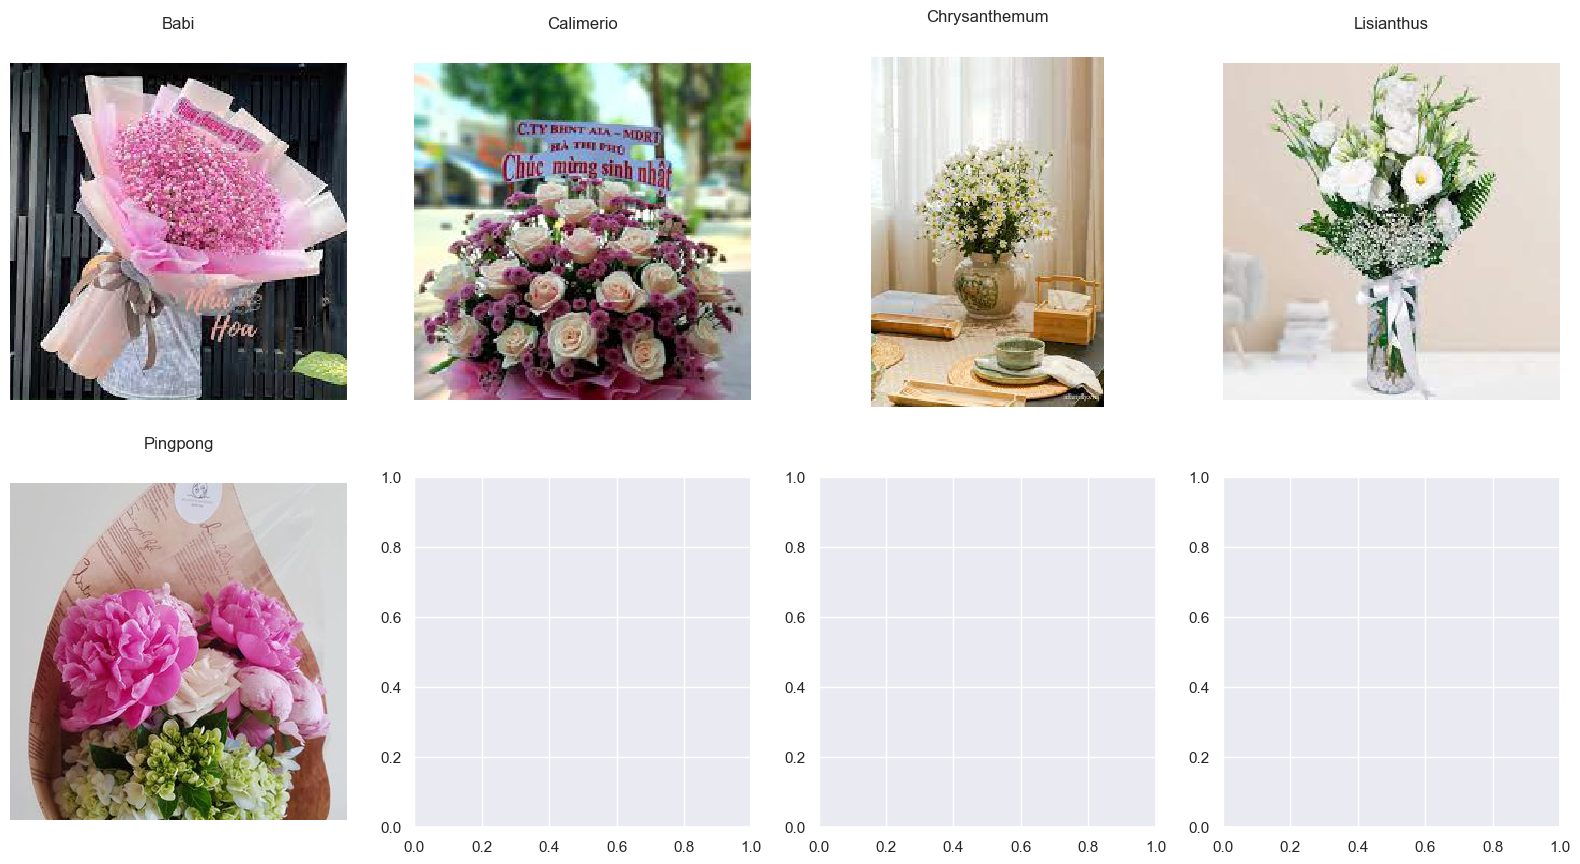

In [3]:
X = []
y = []

img_height = 299
img_width = 299

fig,ax = plt.subplots(2, 4, figsize=(20,10))
ax=ax.flatten()

flowers_dir_path_object = pathlib.Path(flowers_dir)

for label_number,flower in enumerate(flower_labels):
    # get all paths of images inside flower subdirectory
    flower_images_paths = list(flowers_dir_path_object.glob(f'{flower}/*.jpg'))
    ax[label_number].set_title(flower.capitalize())
    ax[label_number].axis('off')
    flower_img = np.array(load_img(flower_images_paths[0].__str__()))
    ax[label_number].matshow(flower_img)
    # print(flower_images_paths[0].__str__())
    for image in flower_images_paths:
        # load and resize image
        resized_image = load_img(str(image),target_size=(img_height, img_width))
        # append features in X and labels in y
        X.append(np.array(resized_image))
        y.append(label_number)
        


In [4]:
import os

def scanData():
    data_count = pd.DataFrame(data={"flower": [], "count": []})
    meta_data_df = pd.DataFrame(data={"image_path": [], "flower_type": []})
    folder_path = flowers_dir

    subdirectories = next(os.walk(folder_path))[1]

    print(subdirectories)

    for i in subdirectories:
        sub = next(os.walk(folder_path+"/"+i))
        
        new_meta_data = pd.DataFrame(data={"image_path": [ (sub[0] + "/" + j) for j in sub[2]] , "flower_type": i})
        meta_data_df = pd.concat([meta_data_df, new_meta_data], ignore_index=True)
        
        new_data = pd.DataFrame(data={"flower": i, "count": len(sub[2])}, index=[0])      
        data_count = pd.concat([data_count, new_data], ignore_index=True)
        print(i, len(sub[2]), len([ sub[0] + j for j in sub[2]]))

    return data_count, meta_data_df

img_count, meta_data = scanData()
img_count

['Babi', 'Calimerio', 'Chrysanthemum', 'Lisianthus', 'Pingpong']
Babi 931 931
Calimerio 348 348
Chrysanthemum 696 696
Lisianthus 963 963
Pingpong 357 357


,flower,count
0,Babi,931.0
1,Calimerio,348.0
2,Chrysanthemum,696.0
3,Lisianthus,963.0
4,Pingpong,357.0


<Axes: xlabel='flower', ylabel='count'>

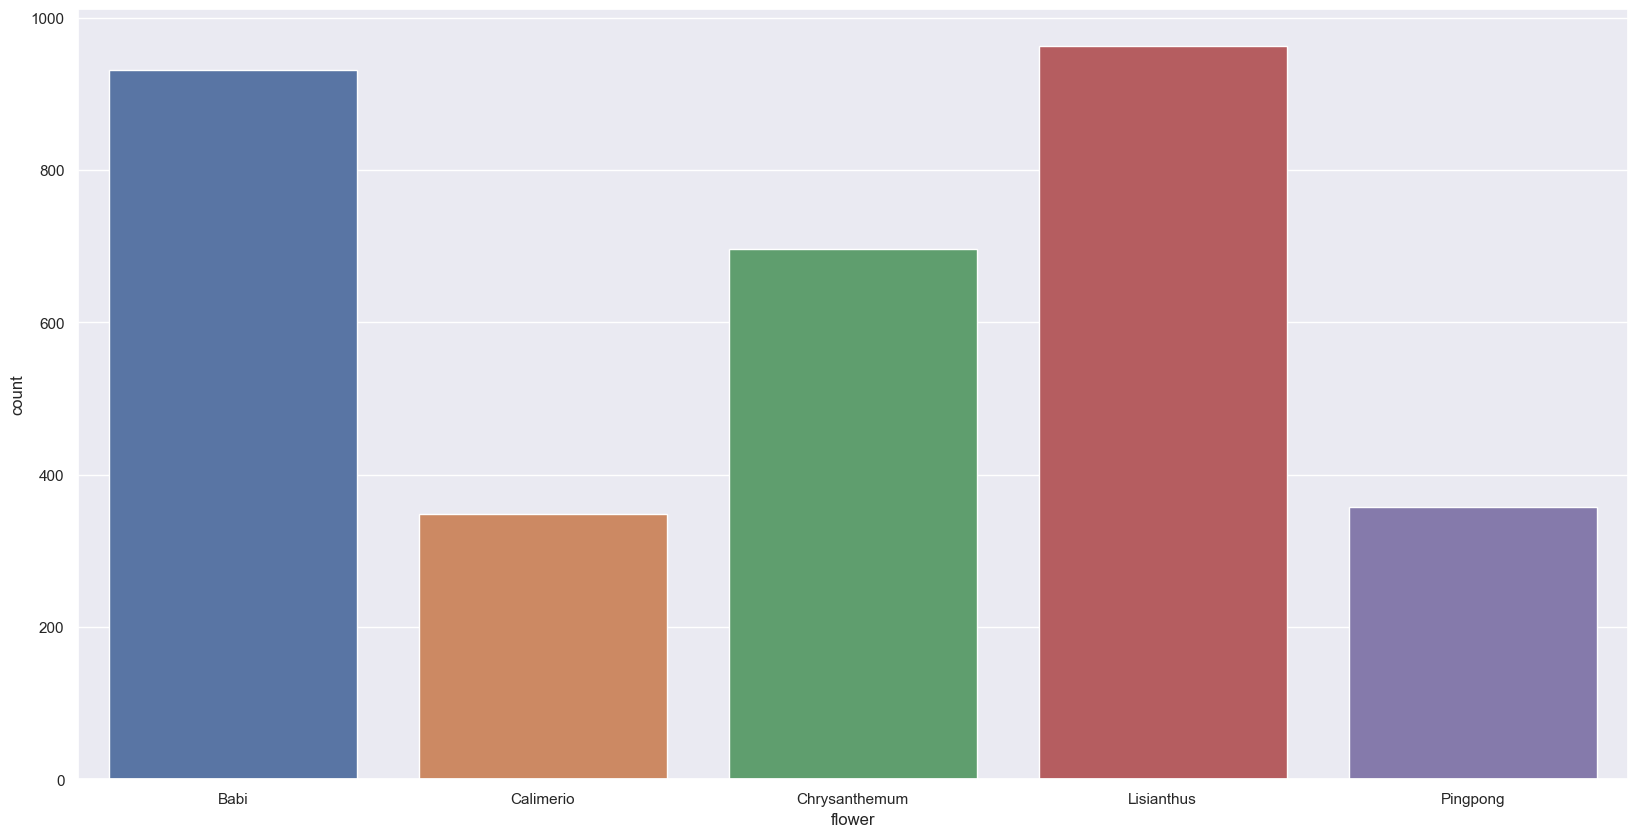

In [5]:
plt.figure(figsize=(20,10))
sns.barplot(data=img_count, x='flower', y='count')

In [6]:
X = np.array(X)
y = np.array(y)

print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (3295, 299, 299, 3)
y shape: (3295,)


## Model Building

* Train test split
* Fine-tuning pre-trained model
* Model evaluation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))

X train shape: (2471, 299, 299, 3)
X test shape: (824, 299, 299, 3)


In [9]:


model = tf.keras.Sequential([
    
    
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5",trainable=True),
    
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', 
#                            input_shape=(img_height, img_width)),
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     #VGG block 2
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     #VGG block 3
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#         #VGG block 3
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#         #VGG block 3
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
    
#     tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='softmax')
])

model.compile( optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
Total params: 22,075,392
Trainable params: 22,040,960
Non-trainable params: 34,432
_________________________________________________________________


In [10]:
# feature_history = feature_extraction.fit(X_train,y_train,batch_size=64,validation_split=0.2,epochs=10)

In [11]:
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=100)
# rf.fit(feature_extraction.predict(X_train), y_train)


In [12]:
# from sklearn.metrics import classification_report
# print(classification_report(y_train, feature_extraction.predict(X_train)))
# print("-"*50)
# print(classification_report(y_test, feature_extraction.predict(X_test)))
# res = [np.argmax(value) for value in feature_extraction.predict(X_train)]

In [13]:
history = model.fit(X_train,y_train,batch_size=64,validation_split=0.2,epochs=10)

Epoch 1/10
31/31 [==============================] - 156s 5s/step - loss: 1.0942 - accuracy: 0.7368 - val_loss: 5.5452 - val_accuracy: 0.2889
Epoch 2/10
31/31 [==============================] - 193s 6s/step - loss: 0.6956 - accuracy: 0.8497 - val_loss: 32.9394 - val_accuracy: 0.1091
Epoch 3/10
31/31 [==============================] - 197s 6s/step - loss: 0.5386 - accuracy: 0.9028 - val_loss: 4.1701 - val_accuracy: 0.2424
Epoch 4/10
11/31 [=========>....................] - ETA: 2:06 - loss: 0.4379 - accuracy: 0.9332

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
model.metrics_names

In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.axhline(y = max(train_metric), color = 'r', linestyle = '-')
    plt.axhline(y = max(val_metric), color = 'b', linestyle = '-')

    plt.show()

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
flower_labels

In [ ]:
predictions = model.predict(X_test)
max_predictions = [np.argmax(value) for value in predictions]
max_predictions[:5]
confusion_matrix_result = confusion_matrix(y_test,max_predictions)

labels = flower_labels
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_result,annot=True,cmap='Reds',fmt='.0f',xticklabels=labels,yticklabels=labels)
plt.title('Flower Recognition')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()

In [ ]:
classification_report_result = classification_report(y_test,max_predictions)
print(classification_report_result)

## Saving the model

In [ ]:
model.save('/kaggle/working/flower_recognition_pretrained.h5')